# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание целей и задачи проекта**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Необходимо построить модель для определения стоимости.

Заказчику важны:

- качество предсказания
- скорость предсказания
- время обучения

**Описание данных**

Таблица с историческими данными: технические характеристики, комплектации и цены автомобилей.
Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:
- Price — цена (евро)

**План работы**

- загрузить и познакомиться с данными
- изучить данные, заполнить пропущенные значения и обработать аномалии в столбцах (если среди признаков имеются неинформативные - удалить)
- подготовить выборки для обучения моделей
- обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг (для каждой модели попробоваьб разные гиперпараметры)
- проанализировать время обучения, время предсказания и качество моделей
- опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке
    
    Примечания:
    для оценки качества моделей применить метрику RMSE.
    Значение метрики RMSE должно быть меньше 2500.

## Подготовка данных

In [1]:
# импортируем нужные библиотеки
import os
import time
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm

# модели
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

In [2]:
# пути к файлам
pth1 = '/datasets/autos.csv'
pth2 = '/Users/refresh/Downloads/autos.csv'

# открытие файлов
if os.path.exists(pth1):
    auto = pd.read_csv(pth1)
elif os.path.exists(pth2):
    auto = pd.read_csv(pth2)
else:
    print('Что-то пошло не так')

In [3]:
# знакомимся с информацией
display(auto.sample(5))
auto.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
144970,2016-03-20 16:57:41,2500,wagon,2005,manual,116,focus,150000,12,gasoline,ford,no,2016-03-20 00:00:00,0,82377,2016-03-20 17:44:09
341115,2016-03-14 22:53:01,5500,sedan,2004,manual,102,golf,125000,10,petrol,volkswagen,no,2016-03-14 00:00:00,0,16515,2016-03-15 19:47:20
328756,2016-03-18 13:37:36,2500,convertible,1992,manual,160,cr_reihe,150000,6,petrol,honda,no,2016-03-18 00:00:00,0,69181,2016-04-05 22:17:21
280149,2016-03-31 07:57:37,13990,sedan,2014,manual,125,focus,50000,10,petrol,ford,no,2016-03-31 00:00:00,0,1217,2016-04-06 02:17:25
192696,2016-03-07 00:51:49,2999,sedan,1987,NaN,0,other,150000,3,petrol,lada,no,2016-03-06 00:00:00,0,79618,2016-04-07 07:15:30


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
# пропуски
auto.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [5]:
# описание числовых признаков
auto.describe(include = 'all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


**Вывод по ознакомлению с данными**

- столбцы в таблице соделжат заглавные буквы
- в таблице есть пропуски
- данные содержат как колличественные, так и категориальные признаки
- с типами данных всё в порядке
- некоторые данные, такие как:
    - RegistrationMonth — месяц регистрации автомобиля
    - DateCreated — дата создания анкеты
    - NumberOfPictures — количество фотографий автомобиля
    - PostalCode — почтовый индекс владельца анкеты (пользователя)
    - LastSeen — дата последней активности пользователя

    могут не представлять информативности для модели, необходимо рассмотреть их подробнее и не нужные удалить.
- в данных есть аномальные значения

Удалим данные не нужные для обучения маодели.

In [6]:
auto = auto.drop(['RegistrationMonth',
                  'DateCreated',
                  'NumberOfPictures',
                  'PostalCode',
                  'LastSeen'], axis=1)

In [7]:
# переименовываем столбцы
auto = auto.rename(
columns={
    'DateCrawled' : 'date_crawled',
    'Price' : 'price',
    'VehicleType' : 'vehicle_type',
    'RegistrationYear' : 'registration_year',
    'Gearbox' : 'gearbox',
    'Power' : 'power',
    'Model' : 'model',
    'Kilometer' : 'kilometer',
    'FuelType' : 'fuel_type',
    'Brand' : 'brand',
    'NotRepaired' : 'not_repaired'}
)

Рассмотрим данные подробнее.

### price

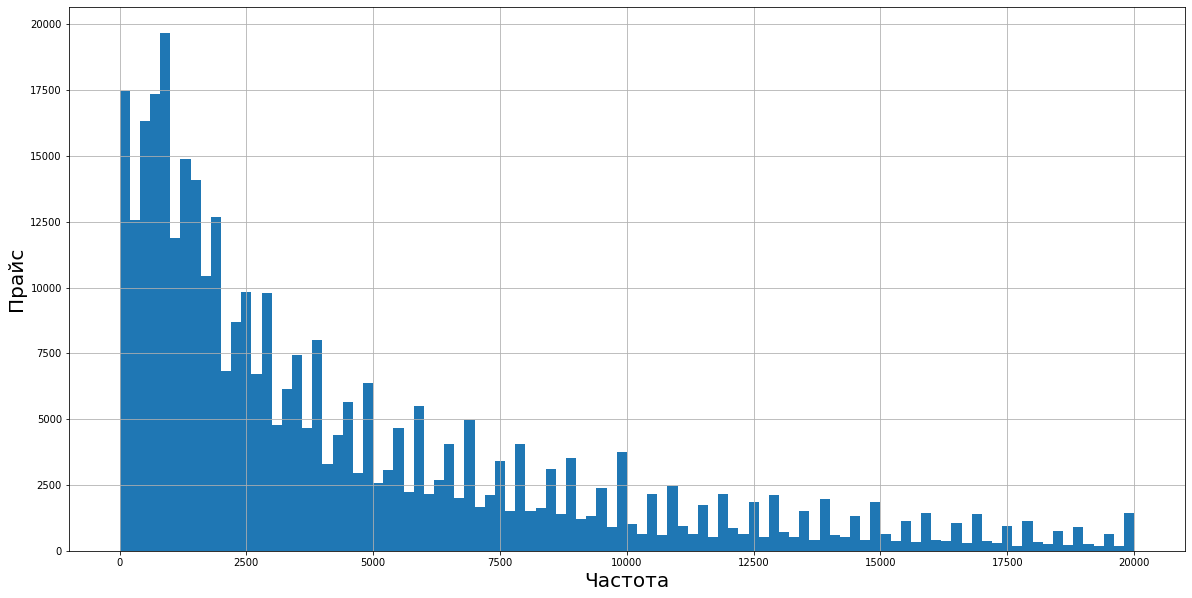

In [8]:
# строим гистограмму
plt.figure(figsize=(20, 10))
auto['price'].hist(bins=100)
plt.xlabel("Частота", fontsize=20)
plt.ylabel("Прайс", fontsize=20);

Дорогими машины быть могут, но нулевые цены смотряться странно. Рассмотрим значения около нуля, выберем порог не более 500 евро (разбитые или сломаные машины могут продвать по низкой цене).

In [9]:
auto[auto['price'] < 500]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,petrol,ford,NaN
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,petrol,volkswagen,NaN
23,2016-03-12 19:43:07,450,small,1997,manual,50,arosa,150000,petrol,seat,no
...,...,...,...,...,...,...,...,...,...,...,...
354318,2016-03-15 19:57:11,400,wagon,1991,manual,0,legacy,150000,petrol,subaru,NaN
354329,2016-03-30 20:55:30,350,small,1996,NaN,65,punto,150000,NaN,fiat,NaN
354335,2016-04-04 14:41:28,390,small,1997,auto,0,corsa,100000,petrol,opel,yes
354338,2016-03-31 19:52:33,180,NaN,1995,NaN,0,NaN,125000,petrol,opel,NaN


Поскольку наше задание связано с предсказанием цены, удалим аномальные значения, чтобы модель не обучалась на них.

In [10]:
auto = auto[auto['price'] >= 500]

### vehicle_type

In [11]:
# смотрим значения
auto['vehicle_type'].value_counts()

sedan          85475
small          68289
wagon          60740
bus            27835
convertible    19549
coupe          14844
suv            11715
other           2774
Name: vehicle_type, dtype: int64

На примере одной модели посмотрим значения кузовов (к примеру "meriva"):

In [12]:
auto.loc[(auto['model'] == 'meriva'), 'vehicle_type'].value_counts()

bus      783
small     55
wagon     42
sedan     33
other     10
suv        3
coupe      1
Name: vehicle_type, dtype: int64

Как видно, у одной и той же модели может быть много значений. Можно заполнить модой, но заполним значением "no_value", которое будет сообщать о пропущенном значении.

In [13]:
# заполняем значением no_value
auto['vehicle_type'] = auto['vehicle_type'].fillna('no_value')

### registration_year

In [14]:
# смотрим значения
auto['registration_year'].value_counts()

2005    21055
2000    19872
2006    19614
1999    19554
2003    19249
        ...  
5300        1
8888        1
7100        1
4800        1
2290        1
Name: registration_year, Length: 131, dtype: int64

Посмотрим когда были скачаны анкеты

In [15]:
auto['date_crawled'] =  pd.to_datetime(auto['date_crawled'], format='%Y%m%d %H:%M:%S')
pd.DatetimeIndex(auto['date_crawled']).year.value_counts()

2016    318315
Name: date_crawled, dtype: int64

Присутсвуют данные только за 2016 год. Посмотрим регистрировались ли машины после этого года.

In [16]:
auto.loc[auto['registration_year'] > pd.DatetimeIndex(auto['date_crawled']).year]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
22,2016-03-23 14:52:51,2900,no_value,2018,manual,90,meriva,150000,petrol,opel,no
26,2016-03-10 19:38:18,5555,no_value,2017,manual,125,c4,125000,NaN,citroen,no
48,2016-03-25 14:40:12,7750,no_value,2017,manual,80,golf,100000,petrol,volkswagen,NaN
51,2016-03-07 18:57:08,2000,no_value,2017,manual,90,punto,150000,gasoline,fiat,yes
57,2016-03-10 20:53:19,2399,no_value,2018,manual,64,other,125000,NaN,seat,no
...,...,...,...,...,...,...,...,...,...,...,...
354112,2016-03-11 15:49:51,3600,no_value,2017,manual,86,transit,150000,gasoline,ford,NaN
354140,2016-03-29 16:47:29,1000,no_value,2017,manual,101,a4,150000,NaN,audi,NaN
354203,2016-03-17 00:56:26,2140,no_value,2018,manual,80,fiesta,150000,NaN,ford,no
354253,2016-03-25 09:37:59,1250,no_value,2018,NaN,0,corsa,150000,petrol,opel,NaN


Получается, что анкеты скачаны в 2016 году, а машины поставлены на учёт в последующих годах. Удалим строки с эти парадоксом.

In [17]:
auto = auto.loc[auto['registration_year'] <= 2016]

Удалим столец DateCrawled, т к он для обцчения модели не несёт информации.

In [18]:
auto = auto.drop('date_crawled', axis=1)

На крупных сайтах auto.ru и avito.ru минимальный год в продаже 1922. 

In [19]:
auto.loc[(auto['registration_year'] < 1922), 'registration_year'].count()

41

Исключим эти значения.

In [20]:
auto = auto[auto['registration_year'] < 2022]
auto = auto[auto['registration_year'] > 1922]

### gearbox

In [21]:
# смотрим значения
auto['gearbox'].value_counts()

manual    231875
auto       61568
Name: gearbox, dtype: int64

In [22]:
# заполняем значением no_value
auto['gearbox'] = auto['gearbox'].fillna('no_value')

### power

In [23]:
auto['power'].value_counts()

0       25464
75      19668
150     13446
140     12220
60      12074
        ...  
952         1
805         1
953         1
645         1
1895        1
Name: power, Length: 654, dtype: int64

В данных есть как нулевые, так и огромные значения. На крупных сайтах auto.ru и avito.ru максимальная мощьность составляет 1020, далее могут быть уже идивидуальные автомобили, но их стоимость уникальна.  Минимальное значения, из этих же источников, для автомобиля 7 лошадиных сил. Посмотрим сколько таких данных и удали их.

In [24]:
auto[auto['power']>1020]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
7661,1499,small,1999,manual,7515,lupo,150000,petrol,volkswagen,NaN
7720,1500,small,2000,manual,1400,NaN,150000,petrol,honda,NaN
9664,2599,no_value,2016,manual,1779,zafira,150000,petrol,opel,no
9875,550,wagon,2003,manual,1753,focus,150000,gasoline,ford,yes
...,...,...,...,...,...,...,...,...,...,...
346639,1300,sedan,2000,manual,12512,carisma,150000,petrol,mitsubishi,NaN
348137,850,sedan,1993,auto,9012,golf,150000,petrol,volkswagen,NaN
348237,3000,coupe,2007,manual,2007,corsa,150000,gasoline,opel,yes
348668,1000,wagon,1996,manual,2598,a6,150000,NaN,audi,NaN


In [25]:
auto[auto['power']<7]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
37,1500,no_value,2016,no_value,0,kangoo,150000,gasoline,renault,no
54,4700,wagon,2005,manual,0,signum,150000,NaN,opel,no
55,550,wagon,1999,manual,0,astra,150000,gasoline,opel,yes
69,1200,coupe,2001,no_value,0,astra,150000,NaN,opel,NaN
70,800,small,1993,manual,0,polo,150000,petrol,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...
354336,3299,no_value,2005,auto,0,outlander,150000,petrol,mitsubishi,NaN
354346,2600,no_value,2005,auto,0,c_klasse,150000,NaN,mercedes_benz,NaN
354360,3999,wagon,2005,manual,3,3er,150000,gasoline,bmw,no
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no


In [26]:
auto = auto.loc[(auto['power'] <= 1020) & (auto['power'] > 7)]

### model

In [27]:
# заполняем значением no_value
auto['model'] = auto['model'].fillna('no_value')

### kilometer

In [28]:
# смотрим данные
auto['kilometer'].describe()

count    279373.000000
mean     127716.314748
std       36925.832884
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

В норме.

### fuel_type

In [29]:
# смотрим значения
auto['fuel_type'].value_counts()

petrol      174225
gasoline     87020
lpg           4592
cng            466
hybrid         200
other           77
electric        62
Name: fuel_type, dtype: int64

In [30]:
# заполняем значением no_value
auto['fuel_type'] = auto['fuel_type'].fillna('no_value')

### brand

In [31]:
# смотрим значения
auto['brand'].value_counts()

volkswagen        60310
bmw               31576
opel              29087
mercedes_benz     27076
audi              25002
ford              18421
renault           12427
peugeot            8848
fiat               6839
seat               5451
skoda              4867
smart              4456
mazda              4406
citroen            4005
toyota             3969
nissan             3726
hyundai            3024
mini               2950
volvo              2678
honda              2250
mitsubishi         2233
kia                2030
alfa_romeo         1863
suzuki             1836
sonstige_autos     1652
chevrolet          1453
chrysler           1112
dacia               800
porsche             620
subaru              581
jeep                578
daihatsu            514
land_rover          465
saab                453
jaguar              435
lancia              337
daewoo              330
rover               306
trabant             252
lada                155
Name: brand, dtype: int64

В норме.

### not_repaired

In [32]:
# смотрим значения
auto['not_repaired'].value_counts()

no     219461
yes     23125
Name: not_repaired, dtype: int64

In [33]:
# заполняем значением no_value
auto['not_repaired'] = auto['not_repaired'].fillna('no_value')
# проверка
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279373 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              279373 non-null  int64 
 1   vehicle_type       279373 non-null  object
 2   registration_year  279373 non-null  int64 
 3   gearbox            279373 non-null  object
 4   power              279373 non-null  int64 
 5   model              279373 non-null  object
 6   kilometer          279373 non-null  int64 
 7   fuel_type          279373 non-null  object
 8   brand              279373 non-null  object
 9   not_repaired       279373 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.4+ MB


Проверим на зависимость признаки.

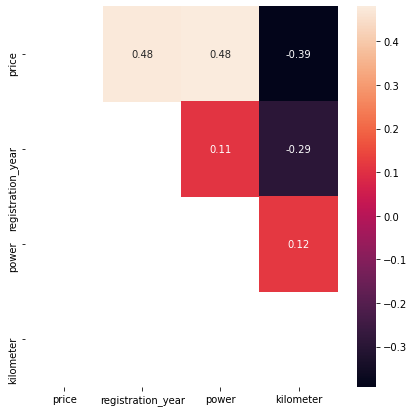

In [34]:
# строим треугольную тепловую матрицу с коэффициентом корреляции
m = np.tril(auto.corr())
plt.figure(figsize=(7, 7))
sb.heatmap(auto.corr(), mask=m, annot=True);

**Вывод**

В данных много пропусков и аномальных значений. Мы их предобработали и данные готовы к дальнейшему анализу.

В признаках нет сильных зависимостей.

## Обучение моделей

In [35]:
# функция для вычисления MRSE
def error(target,predict):
    result = mean_squared_error(target,predict, squared=False)
    return result
# скорер
scorr  = make_scorer(error, greater_is_better=False)

Подготовим признаки для моделей

In [36]:
warnings.filterwarnings("ignore")

# формируем признаки и целевой признак
features = auto.drop('price', axis=1)
target = auto['price']
# выделяем выборки
features_train, features_test, target_train, target_test = train_test_split(features, target,\
                                                            test_size=.25, random_state=42)
# выделяем категориальные и численные данные
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
num_features = ['registration_year','power', 'kilometer']

# порядковое кодирование
encoder = OrdinalEncoder()
features_train[cat_features] = encoder.fit_transform(features_train[cat_features])
features_test[cat_features] = encoder.fit_transform(features_test[cat_features])

# создадим объект этой структуры StandardScaler
scaler = StandardScaler()
# обучаем
scaler.fit(features_train[num_features])
# преобразуем выборки
features_train[num_features] = scaler.transform(features_train[num_features])
features_test[num_features] = scaler.transform(features_test[num_features])

In [37]:
# код ревьюера
# ДО

ftrain, _ = train_test_split(features, test_size=.25, random_state=42)
ftrain.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
253732,small,2005,manual,60,corsa,150000,petrol,opel,no
318148,wagon,2002,auto,170,c_klasse,150000,gasoline,mercedes_benz,no
289128,wagon,2004,auto,204,e_klasse,150000,gasoline,mercedes_benz,no
196135,small,2007,manual,67,getz,150000,petrol,hyundai,no
312559,sedan,2005,manual,140,a_klasse,150000,gasoline,mercedes_benz,no


In [38]:
# код ревьюера
# ПОСЛЕ


ftrain, _ = train_test_split(features, test_size=.25, random_state=42)
# порядковое кодирование
encoder = OrdinalEncoder()
encoder.fit(ftrain)
ftrain = pd.DataFrame(encoder.transform(ftrain), columns=features_train.columns)

ftrain.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,6.0,74.0,1.0,52.0,83.0,12.0,7.0,24.0,0.0
1,8.0,71.0,0.0,162.0,59.0,12.0,2.0,20.0,0.0
2,8.0,73.0,0.0,196.0,95.0,12.0,2.0,20.0,0.0
3,6.0,76.0,1.0,59.0,113.0,12.0,7.0,12.0,0.0
4,5.0,74.0,1.0,132.0,33.0,12.0,2.0,20.0,0.0


### CatBoost

In [39]:
# запускаем отсчёт времени
start = time.time()
# сохдаём модель и запускаем grid_search
model_cat = CatBoostRegressor(verbose=False, iterations=100, loss_function="RMSE", random_state=42)
grid = {'learning_rate': [0.03, 0.1],
        'max_depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_cat = model_cat.grid_search(grid, X=features_train, y=target_train, plot=True)
# фиксируем время
stop = time.time()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 2274.547658
bestIteration = 99

0:	loss: 2274.5476583	best: 2274.5476583 (0)	total: 3.9s	remaining: 1m 53s

bestTest = 1913.089082
bestIteration = 99

1:	loss: 1913.0890822	best: 1913.0890822 (1)	total: 6.21s	remaining: 1m 26s

bestTest = 2275.138197
bestIteration = 99

2:	loss: 2275.1381969	best: 1913.0890822 (1)	total: 8.58s	remaining: 1m 17s

bestTest = 1918.60159
bestIteration = 99

3:	loss: 1918.6015895	best: 1913.0890822 (1)	total: 11s	remaining: 1m 11s

bestTest = 2274.645946
bestIteration = 99

4:	loss: 2274.6459462	best: 1913.0890822 (1)	total: 13.3s	remaining: 1m 6s

bestTest = 1915.035792
bestIteration = 99

5:	loss: 1915.0357915	best: 1913.0890822 (1)	total: 15.7s	remaining: 1m 2s

bestTest = 2277.419748
bestIteration = 99

6:	loss: 2277.4197479	best: 1913.0890822 (1)	total: 18.1s	remaining: 59.4s

bestTest = 1912.189802
bestIteration = 99

7:	loss: 1912.1898025	best: 1912.1898025 (7)	total: 20.4s	remaining: 56.2s

bestTest = 2276.063224
bestIteration = 99

8:	l

In [40]:
print('CatBoostRegressor для подбора параметров требует', round((stop - start)/60, 2), 'минут')

CatBoostRegressor для подбора параметров требует 2.2 минут


In [41]:
print(f'MRSE {model_cat.get_best_score()}')

MRSE {'learn': {'RMSE': 1643.9011058497917}}


In [42]:
grid_cat

{'params': {'depth': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

Проверим сколько времени лучшей модели CatBoostRegressor требуется на обучение и предсказание:

In [43]:
features_t, features_v, target_t, target_v = train_test_split(features_train, target_train,\
                                                            test_size=.25, random_state=42)
cat = CatBoostRegressor(verbose=20,
                        iterations=100,
                        loss_function="RMSE",
                        random_state=42,
                        depth=10,
                        l2_leaf_reg=1,
                        learning_rate=0.1)
# запускаем отсчёт времени
start = time.time()
cat.fit(features_t, target_t)
# остановка времени
stop = time.time()
print('обучение занимает', round((stop - start)/60, 3), 'мин.')

# запускаем отсчёт времени
start = time.time()
predict = cat.predict(features_v)
# остановка времени
stop = time.time()
print('предсказание занимает', round((stop - start)/60, 4), 'мин.')
print('MRSE на валидационной выборке', error(target_v,predict))

0:	learn: 4284.1282801	total: 46.9ms	remaining: 4.64s
20:	learn: 2029.0987172	total: 1.04s	remaining: 3.91s
40:	learn: 1788.0657764	total: 2.02s	remaining: 2.9s
60:	learn: 1710.6619371	total: 2.98s	remaining: 1.91s
80:	learn: 1666.2687469	total: 3.96s	remaining: 930ms
99:	learn: 1635.1916547	total: 4.87s	remaining: 0us
обучение занимает 0.103 мин.
предсказание занимает 0.0005 мин.
MRSE на валидационной выборке 1688.4771308752822


**Вывод**

Модель CatBoostRegressor показала себя хорошо, MRSE = 1688. Лучшие параметры 
- 'depth': 10, 
- 'l2_leaf_reg': 1, 
- 'learning_rate': 0.1

Обучение занимает 0.103 мин.
Предсказание занимает 0.0005 мин.

### LightGBM

In [45]:
# запускаем отсчёт времени
start = time.time()
# сохдаём модель и запускаем grid_search

model_LGBM = LGBMRegressor(random_state=42, verbose=20)
grid = {'num_leaves': [3, 7, 10],
        'learning_rate': [0.1, 0.03],
        'max_depth': [1, 3, 5]
}

grid_LGBM = GridSearchCV(model_LGBM, grid, cv=3, n_jobs=-1, scoring='neg_root_mean_squared_error')
grid_LGBM.fit(features_train, target_train)
# фиксируем время
stop = time.time()

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.781786
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.185070
[LightGBM] [Debug] init for col-wise cost 0.268552 seconds, init for row-wise cost 0.208513 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.314660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 139686, number of used features: 9
[LightGBM] [Info] Start training from score 5137.325086
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [

In [46]:
print('LGBMRegressor для подбора параметров требует', round((stop - start)/60, 2), 'минут')

LGBMRegressor для подбора параметров требует 55.74 минут


In [47]:
print(f'Лучшие параметры модели {grid_LGBM.best_params_}')

Лучшие параметры модели {'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 10}


In [48]:
print('MRSE', abs(grid_LGBM.best_score_))

MRSE 1825.554644121139


Проверим сколько времени лучшей LGBMRegressor модели требуется на обучение и предсказание:

In [49]:
LGBM = LGBMRegressor(random_state=42,
                     verbose=100,
                     learning_rate=0.1,
                     max_depth=5,
                     num_leaves=10)
# запускаем отсчёт времени
start = time.time()
LGBM.fit(features_t, target_t)
# остановка времени
stop = time.time()

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.781614
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.185104
[LightGBM] [Debug] init for col-wise cost 0.206699 seconds, init for row-wise cost 0.202534 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.317334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 650
[LightGBM] [Info] Number of data points in the train set: 157146, number of used features: 9
[LightGBM] [Info] Start training from score 5137.155524
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
[LightGBM] [Debug] Trained 

In [50]:
print('обучение занимает', round((stop - start)/60, 3), 'мин.')

# запускаем отсчёт времени
start = time.time()
predict = LGBM.predict(features_v)
# остановка времени
stop = time.time()
print('предсказание занимает', round((stop - start)/60, 4), 'мин.')
print('MRSE на валидационной выборке', error(target_v,predict))

обучение занимает 2.029 мин.
предсказание занимает 0.0065 мин.
MRSE на валидационной выборке 1830.08687755358


**Вывод**

Модель LightGBM показала себя так же хорошо, MRSE = 1830. Лучшие параметры
- 'learning_rate': 0.1, 
- 'max_depth': 5, 
- 'num_leaves': 10

Обучение занимает 2.029 мин.
Предсказание занимает 0.0065 мин.

### Ridge

В качестве альтернативы бустингу и "деревянным" алгоритмам возьмем модель линейной регрессии

In [51]:
# формируем признаки и целевой признак
features = auto.drop('price', axis=1)
target = auto['price']
# выделяем выборки
features_train_ridge, features_test_ridge, target_train_ridge, target_test_ridge = train_test_split(features, target,\
                                                            test_size=.25, random_state=42)
# кодируем категориальные признаки
features_train_ridge = pd.get_dummies(features_train_ridge, drop_first=True)
features_test_ridge = pd.get_dummies(features_test_ridge, drop_first=True)
# создадим объект этой структуры StandardScaler
scaler = StandardScaler()
# обучаем
scaler.fit(features_train_ridge[num_features])
# преобразуем выборки
features_train_ridge[num_features] = scaler.transform(features_train_ridge[num_features])
features_test_ridge[num_features] = scaler.transform(features_test_ridge[num_features])
# выделяем выборки
features_t, features_v, target_t, target_v = train_test_split(features_train_ridge, target_train_ridge,\
                                                            test_size=.25, random_state=42)

In [52]:
# запускаем отсчёт времени
start = time.time()

# сохдаём модель и запускаем grid_search

model_ridge = Ridge(random_state=42)

grid = {'alpha' : [50,10, 1, 0.1, 0.01],
        'solver': ['svd']
       }

grid_r = GridSearchCV(model_ridge, param_grid=grid, cv=3, n_jobs=-1) #scoring=error выдаёт nan, не заню почему
grid_r.fit(features_t, target_t)
# фиксируем время
stop = time.time()

In [53]:
print('Ridge требует', round((stop - start)/60, 2), 'минут')

Ridge требует 12.33 минут


In [54]:
print ("Best Params", grid_r.best_params_)

Best Params {'alpha': 1, 'solver': 'svd'}


In [55]:
print ("Best Score", error(target_v, grid_r.best_estimator_.predict(features_v)))

Best Score 2612.92394286503


<div class="alert alert-info" style="border-color: #0080FF; border-radius: 5px">
    <p><u><b>КОММЕНТАРИЙ</b></u></p>
    <p>я прогонял по разным алгоритмам расчёта на локальном компьютере
        
    'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
        
     оставил лучший, чтобы сетевой юпитер не падал. время выполнения было 30 мин.
</p>
</div>

Проверим сколько времени лучшей Ridge модели требуется на обучение и предсказание:

In [56]:
ridge = Ridge(random_state=42, alpha=1, solver='svd')
# запускаем отсчёт времени
start = time.time()
ridge.fit(features_t, target_t)
# остановка времени
stop = time.time()
print('обучение занимает', round((stop - start)/60, 3), 'мин.')

# запускаем отсчёт времени
start = time.time()
predict = ridge.predict(features_v)
# остановка времени
stop = time.time()
print('предсказание занимает', round((stop - start)/60, 4), 'мин.')
print('MRSE на валидационной выборке', error(target_v,predict))

обучение занимает 1.01 мин.
предсказание занимает 0.0036 мин.
MRSE на валидационной выборке 2612.92394286503


**Вывод**

Модель Ridge показала хуже свех, MRSE = 2612. Лучшие параметры:
- 'alpha': 0.1, 
- 'solver': 'svd'

Обучение занимает 1.01 мин.
Предсказание занимает 0.0036 мин.

## Анализ моделей

Лучше всех показала себя модель CatBoostRegressor. Проверим её на тестовой выборке.

In [57]:
cat = CatBoostRegressor(verbose=20,
                        iterations=100,
                        loss_function="RMSE",
                        random_state=42,
                        depth=10,
                        l2_leaf_reg=1,
                        learning_rate=0.1)
# запускаем отсчёт времени
start = time.time()
cat.fit(features_train, target_train)
# остановка времени
stop = time.time()
print('обучение занимает', round((stop - start)/60, 3), 'мин.')

# запускаем отсчёт времени
start = time.time()
predict = cat.predict(features_test)
# остановка времени
stop = time.time()
print('предсказание занимает', round((stop - start)/60, 4), 'мин.')
print('MRSE на валидационной выборке', error(target_test,predict))

0:	learn: 4277.9633918	total: 64.6ms	remaining: 6.39s
20:	learn: 2043.9186904	total: 1.3s	remaining: 4.91s
40:	learn: 1792.0371527	total: 2.49s	remaining: 3.59s
60:	learn: 1721.2344472	total: 3.66s	remaining: 2.34s
80:	learn: 1678.1223152	total: 4.85s	remaining: 1.14s
99:	learn: 1643.9011058	total: 6.01s	remaining: 0us
обучение занимает 0.114 мин.
предсказание занимает 0.0005 мин.
MRSE на валидационной выборке 1707.0819067397924


Проверим модель на адекватность.

In [58]:
constant = pd.DataFrame(columns=['price'], index=range(len(target_test)))
constant['price'] = target.mean()
print('MRSE на константной модели', error(constant, predict))

MRSE на константной модели 4218.329948965177


На одекватность проверка пройдена.

#  Вывод

В данных много пропусков и аномальных значений. Мы их предобработали и подготовили данные к дальнейшему анализу.
В признаках нет сильных зависимостей.

Модель **CatBoostRegressor** показала себя хорошо, MRSE = 1688. Лучшие параметры 
- 'depth': 10, 
- 'l2_leaf_reg': 1, 
- 'learning_rate': 0.1

Обучение занимает 0.114 мин.
Предсказание занимает 0.0005 мин.

Модель **LightGBM** показала себя так же хорошо, MRSE = 1830. Лучшие параметры
- 'learning_rate': 0.1, 
- 'max_depth': 5, 
- 'num_leaves': 10

Обучение занимает 2.029 мин.
Предсказание занимает 0.0065 мин.

Модель **Ridge** показала хуже свех, MRSE = 2612. Лучшие параметры:

- 'alpha': 0.1, 
- 'solver': 'svd'

Обучение занимает 1.01 мин.
Предсказание занимает 0.0036 мин.


MRSE CatBoostRegressor на тестовой выборке 1707, это соответсвует условиям задачи. Модель прошла проверку на адекватность. На обучение  потребовалось 0.114 сек. На предсказание 0.0005 мин.


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей